In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
# GPU 사용확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8065798502600203545,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22010552296
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16187741206286862064
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6"]

In [68]:
TRAINING_DIR = './plant-seedlings-classification/train'

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1. / 255, 
    rotation_range=5,           # 이미지 회전 
    width_shift_range=0.05,     # 가로 방향으로 이동
    height_shift_range=0.05,    # 세로 방향으로 이동
    zoom_range=0.05,            #  이미지 확대
    horizontal_flip=True,       # 횡 방향으로 이미지 반전
    fill_mode= 'reflect',       # 이미지를 이동이나 굴절시켰을때 빈 픽셀 값에 대하여 값을 채우는 방식
    validation_split=0.2        # train/validation 분할 비율
)

train_geneator = datagen.flow_from_directory(TRAINING_DIR,
                                             color_mode='rgb',
                                            class_mode = 'categorical',
                                             batch_size=32,
                                            subset='training',
                                             target_size=(256, 256),
                                            shuffle=True)

valid_geneator = datagen.flow_from_directory(TRAINING_DIR,
                                             color_mode='rgb',
                                            class_mode = 'categorical',
                                             batch_size=32,
                                             target_size=(256, 256),
                                            subset='validation')

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


In [4]:
# 클래스 확인
train_geneator.class_indices

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

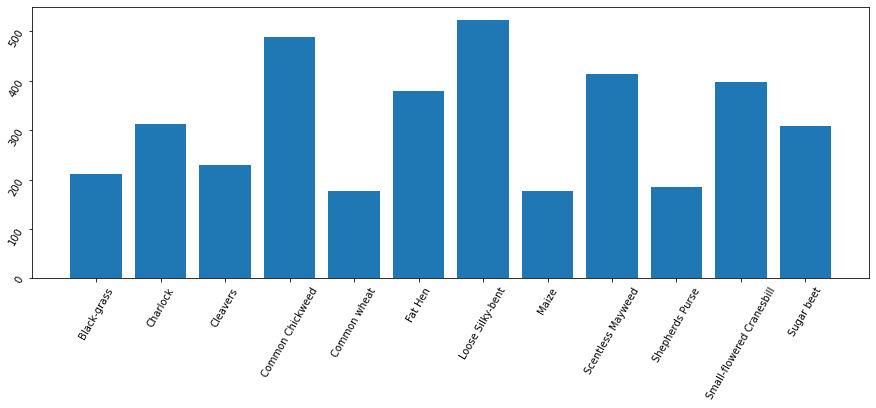

In [5]:
# 클래스별 갯수
unique, counts = np.unique(train_geneator.classes, return_counts=True)
dict1 = dict(zip(train_geneator.class_indices,counts))
keys = dict1.keys()
values = dict1.values()

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(keys, values)
ax.tick_params(rotation=60)

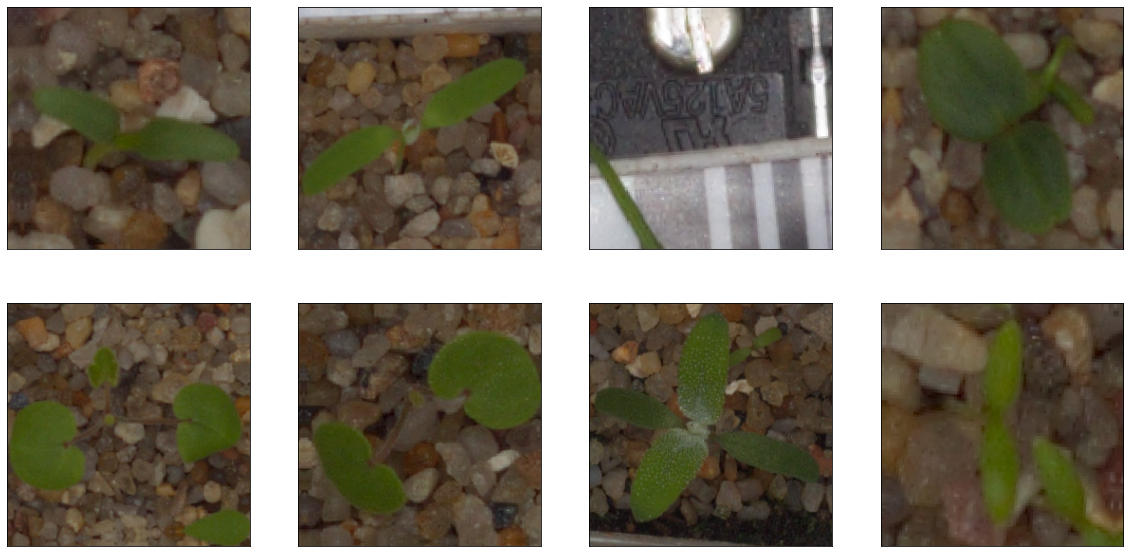

In [6]:
# 이미지 시각화
images = train_geneator[0][0][:8]
labels = train_geneator[0][1][:8]

fig = plt.figure(figsize=(20,10))
axes = np.empty(shape=(0,))

for row_idx in range(2):
    for col_idx in range(4):
        ax = fig.add_subplot(2, 4, row_idx*4 + col_idx + 1)
        ax.tick_params(bottom=False,labelbottom=False,
                      left=False, labelleft=False)
        ax.imshow(images[row_idx*4 + col_idx])
        axes = np.append(axes, ax)

In [3]:
# 모델링
transfer = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
transfer.trainable = False

model = tf.keras.models.Sequential([
    transfer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
   ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9437312   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 12)                396       
Total params: 31,244,620
Trainable params: 9,441,836
Non-trainable params: 21,802,784
_________________________________________________________________


In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [5]:
checkpoint_path = 'plant-seedlings-classification/weights.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                               save_weights_only=True,
                                               save_best_only=True,
                                               monitor='val_loss',
                                               verbose=1)

In [11]:
hist=model.fit(train_geneator,
              validation_data=(valid_geneator),
              epochs=20,
              callbacks=[checkpoint])

Epoch 1/20
119/119 [==============================] - 94s 721ms/step - loss: 2.5426 - acc: 0.2727 - val_loss: 2.0847 - val_acc: 0.2788

Epoch 00001: val_loss improved from inf to 2.08465, saving model to plant-seedlings-classification\weights.ckpt
Epoch 2/20
119/119 [==============================] - 83s 700ms/step - loss: 1.8251 - acc: 0.3902 - val_loss: 1.7261 - val_acc: 0.4403

Epoch 00002: val_loss improved from 2.08465 to 1.72610, saving model to plant-seedlings-classification\weights.ckpt
Epoch 3/20
119/119 [==============================] - 82s 686ms/step - loss: 1.6699 - acc: 0.4454 - val_loss: 1.7466 - val_acc: 0.4477

Epoch 00003: val_loss did not improve from 1.72610
Epoch 4/20
119/119 [==============================] - 82s 690ms/step - loss: 1.5412 - acc: 0.4980 - val_loss: 1.3661 - val_acc: 0.5649

Epoch 00004: val_loss improved from 1.72610 to 1.36609, saving model to plant-seedlings-classification\weights.ckpt
Epoch 5/20
119/119 [==============================] - 82s 688

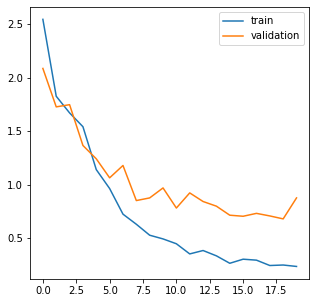

In [17]:
# loss 그래프
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(hist.history['loss'], label='train')
ax.plot(hist.history['val_loss'], label='validation')
ax.legend()

plt.show()

In [6]:
# 모델에 가중치 적용
model.load_weights(checkpoint_path)

In [10]:
# 테스트 이미지 불러오기
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('./plant-seedlings-classification/',
                                                 classes=['test'],
                                                 class_mode='categorical',
                                                 color_mode='rgb',
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 shuffle=False,
                                                 )

Found 794 images belonging to 1 classes.


In [16]:
prediction = model.predict(test_generator).argmax(axis=-1)

In [61]:
submission = pd.DataFrame()
submission['file'] = test_generator.filenames
submission['file'] = submission['file'].str.replace('\\', ' ')
submission['file'] = submission['file'].str.replace('test ','')

c:\users\lab-gpu\anaconda3\envs\choi\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


In [96]:
species_list = list(train_geneator.class_indices.keys())

species = []
for pred in prediction:
    species.append(species_list[pred])

submission['species'] = species
submission.to_csv('plant-seedlings-classification/submission.csv', index=False)

In [100]:
!kaggle competitions submit -c plant-seedlings-classification -f plant-seedlings-classification/submission.csv -m "Message"

Successfully submitted to Plant Seedlings Classification



  0%|          | 0.00/22.9k [00:00<?, ?B/s]
 35%|###4      | 8.00k/22.9k [00:00<00:00, 66.7kB/s]
100%|##########| 22.9k/22.9k [00:04<00:00, 5.28kB/s]
